You have a vehicle that can only drive forward at 1-m/s and has a minimum turning radius of 2-m (remember that radius=1/curvature and that thetadot = speed * curvature). The workspace consists of polygonal obstacles. Develop an RRT planner that can plan paths from a starting position and orientation to a goal position and orientation.

1. Demonstrate the forward kinematics by plotting 11 possible trajectories for a vehicle with a constant curvature starting at $(x,y,\theta)=(5,5,\pi/4)$ and a timestep of 5 seconds.
2. Add an obstacle as a polygon with the following vertices `[[8,6],[10,7],[10,10],[6,10],[6,9]]`. Show that some of the trajectories intersect the obstacle. Is it useful to keep these trajectories in the graph? If not, could they be made useful?
3. Turn your trajectories from part 2 into a graph. Search the graph for the node that is closest to $(10,0,-\pi/2)$. Note that you will need to come up with your own definition for "closest" in configuration space. This doesn't have to be a true metric like in a metric space. Plot the trajectories, the desired point, and the closest point.
4. With the vehicle starting at the node from part 3, using a timestep of 1 second, compute the control input that would get you closest to $(10,0,-\pi/2)$. Make a plot similar to part 3, but add the best trajectory to it.
5. With no obstacles, try to plan a path from $(5,5,\pi/4)$ to $(20,12,\pi/2$ with no randomness by always selecting the trajectory that minimizes your distance to the goal. Does your path converge to the goal?
5. Combine everything from the previous steps into an RRT planner. Then plan a path to the point $(12, 12,\pi/2)$

<IPython.core.display.Javascript object>


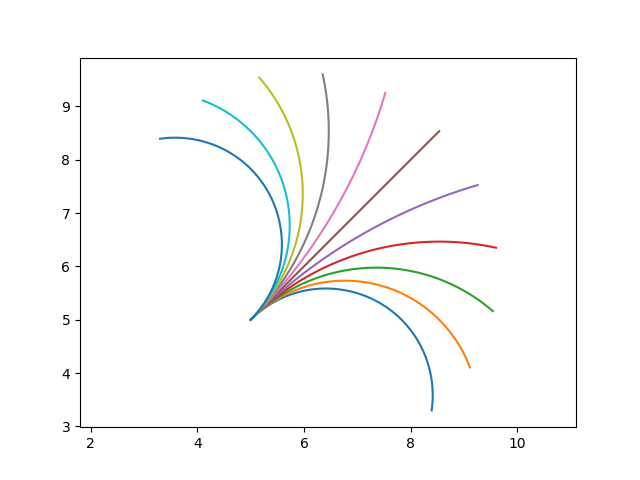

(2.9842831738707756, 9.915375176881103, 2.984283173870771, 9.915375176881106)

In [35]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import shapely.geometry as geom
import descartes as dc
%matplotlib notebook

start_q = (5,5,np.pi/4)
delta_t = 5

def fk(t, state, u):
        x = state[0]
        y = state[1]
        theta = state[2]
        
        s = 1
        k = u[0]

        xdot = s*np.cos(theta)
        ydot = s*np.sin(theta)
        thetadot = k*s
        
        return [xdot, ydot, thetadot]

max_k = 0.5
min_k = -max_k

ks = np.linspace(min_k, max_k, 11)
ts = np.linspace(0,delta_t)

trajectories = []
for k in ks:
    res = scipy.integrate.solve_ivp(fk, [0,delta_t], start_q, t_eval = ts, args=[[k]])
    trajectories.append(res.y)

plt.figure()
for traj in trajectories:
    plt.plot(traj[0],traj[1])
plt.axis('equal')

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<IPython.core.display.Javascript object>


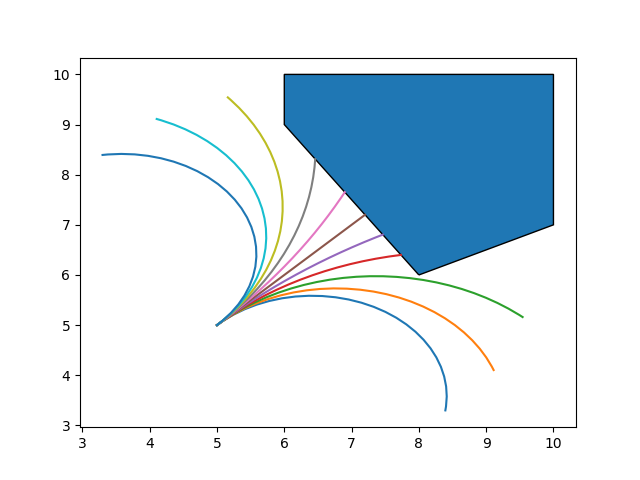

In [36]:
obs_pts = [[8,6],[10,7],[10,10],[6,10],[6,9]]
obs = geom.Polygon(obs_pts)
obs_patch = dc.PolygonPatch(obs)

def collision(t, state, u):
    pt = geom.Point(state[0], state[1])
    if obs.contains(pt):
        return -1.0
    else:
        return 1.0
    
collision.terminal = True
# collision.direction = -1

trajectories = []
for k in ks:
    res = scipy.integrate.solve_ivp(fk, [0,delta_t], start_q, max_step=0.2, args=[[k]], events=[collision])
    trajectories.append(res.y)

fig, ax = plt.subplots()
ax.add_patch(obs_patch)
for traj in trajectories:
    ax.plot(traj[0],traj[1])


In [37]:
def arc_dist(q1, q2):
    p1x = q1[0]
    p2x = q2[0]
    p1y = q1[1]
    p2y = q2[1]

    u1x = np.cos(q1[2])
    u1y = np.sin(q1[2])
    u2x = np.cos(q2[2])
    u2y = np.sin(q2[2])

    delpx = p1x-p2x
    delpy = p1y-p2y

    b = 2*delpx*u2y-2*delpy*u2x
    c = delpx**2 + delpy**2

    k = -b/c

    cx = p2x - u2y/k
    cy = p2y + u2x/k
    numerator = (p1x-cx)*(p2y-cy) - (p1y-cy)*(p2x-cx)
    denominator = (p1x-cx)*(p2x-cx) + (p1y-cy)*(p2y-cy)
    # temp = numerator*k**2
    # phi = np.arcsin(min(max(temp, -1), 1))
    phi = np.arctan2(numerator, denominator)

    d = np.remainder(phi/k, np.abs(2*np.pi/k))

    theta1 = q1[2]
    theta2 = q2[2]
    tangle = theta2-phi

    omega = theta1-tangle

    if abs(k) > max_k:
        d += 100*(abs(k)-max_k)/max_k

    return d + 10*abs(omega)


print(arc_dist((0, 0, np.pi/2), (10, 0, np.pi/2)))
print(arc_dist((0, 0, np.pi/2), (5, 5, 0)))
print(arc_dist((0, 0, np.pi/2-0.1), (-5, 5, np.pi)))
print(arc_dist((0, 0, np.pi/2), (-5, -5, 0)))

47.12388980384689
7.853981633974483
8.853981633974486
23.561944901923447


0 [ 8.39356915  3.29916569 -1.71460184]
1 [ 9.11084352  4.10400836 -1.21460184]
2 [ 9.54141165  5.16082481 -0.71460184]
3 [7.73351741 6.39972389 0.16109923]
4 [7.46377407 6.8043389  0.47881682]
5 [7.2        7.2        0.78539816]
6 [6.89917    7.651245   1.11298901]
7 [6.4594164  8.3108754  1.52584949]
8 [5.16082481 9.54141165 2.28539816]
9 [4.10400836 9.11084352 2.78539816]
10 [3.29916569 8.39356915 3.28539816]


/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<IPython.core.display.Javascript object>


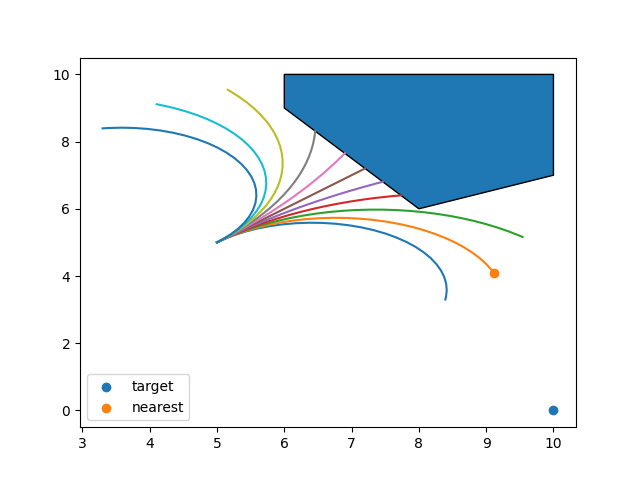

In [39]:
import heapq
import copy
import numpy as np


class Node():
    def __init__(self, xy, hfunc):
        self.neighbors = {}
        self.g = np.Inf
        self.xy = np.array(xy)
        self.hfunc = hfunc
        self.terminal = False

    def __lt__(self, other):
        lt = False
        f1 = self.g+self.hfunc(self.xy)
        f2 = other.g+self.hfunc(self.xy)
        if np.abs(f1-f2) < 0.001:
            #print("almost equal")
            lt = self.g > other.g
        else:
            lt = f1 < f2

        #lt = f1 < f2
        return lt

    def __eq__(self, other):
        return all(self.xy == other.xy)

    def __call__(self):
        return self.hfunc(np.array([self.x, self.y]))
        try:
            return self.f
        except:
            self.f = self.g+self.hfunc(np.array([self.x, self.y]))
            return self.f


class Graph():
    def __init__(self, dist_func):
        self.nodes = {}
        self.dist_func = dist_func

    def __iadd__(self, t):
        n1 = t[0]
        n2 = t[1]
        u = t[2]
        self.connect(n1, n2, u)
        return self

    def connect(self, n1, n2, u):
        try:
            self.nodes[n1].neighbors[n2] = u
        except KeyError:
            self.nodes[n1] = Node(n1, self.hfunc)
            self.nodes[n1].neighbors[n2] = u
        try:
            self.nodes[n2].prev = n1
        except KeyError:
            self.nodes[n2] = Node(n2, self.hfunc)
            self.nodes[n2].prev = n1

    def draw(self, ax):
        for pt in self.nodes:
            node = self.nodes[pt]
            for neighbor in node.neighbors:
                ax.plot([pt[0], neighbor[0]], [pt[1], neighbor[1]], 'k')

    def hfunc(self, node):
        return self.dist_func(node, self.goal)

    def nearest(self, q):
        min_node = None
        min_dist = np.Inf
        for n in self.nodes:
            if self.nodes[n].terminal:
                continue
            dist = self.dist_func(n, q)
            if dist < min_dist:
                min_node = n
                min_dist = dist
        return min_node


def SE2dist(q1, q2):
    pos_dist = np.sqrt((q1[0]-q2[0])**2 + (q1[1]-q2[1])**2)
    angle_dist = np.abs(q1[2]-q2[2])

    return np.linalg.norm(np.array(q1)-np.array(q2))


g = Graph(arc_dist)
for i in range(len(ks)):
    print(i, trajectories[i][:, -1])
    g += (start_q, tuple(trajectories[i][:, -1]), ks[i])

target_pt = (10, 0, -np.pi/2)
near_pt = g.nearest(target_pt)

obs_patch = dc.PolygonPatch(obs)
fig, ax = plt.subplots()
ax.add_patch(obs_patch)
for traj in trajectories:
    ax.plot(traj[0], traj[1])
ax.scatter(target_pt[0], target_pt[1], label="target")
ax.scatter(near_pt[0], near_pt[1], label="nearest")
plt.legend()

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<IPython.core.display.Javascript object>


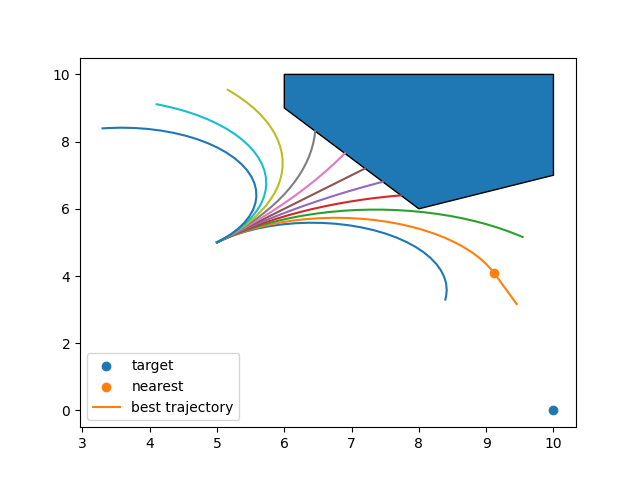

In [41]:
def step(q1, k, timestep):
    res = scipy.integrate.solve_ivp(fk, [0, timestep], q1, max_step=0.2, args=[
                                    [k]], events=[collision])
#     print(res)
    collided = len(res.t_events[0]) > 0
    return res.y, collided


def get_best_control(q1, q2, timestep):
    collided = False

    def final_dist(k):
        #         print(k)
        s, collided = step(q1, k, timestep)
#         print(s)

        final_q = s[:, -1]
        return arc_dist(final_q, q2)

    res = scipy.optimize.minimize(
        final_dist, 0, bounds=[(min_k, max_k)], tol=0.001, options={"maxiter": 100})
    best_traj, collided = step(q1, res.x, timestep)
    return res.x, best_traj, collided


# ks = np.linspace(min_k, max_k, 11)
#
# fig,ax = plt.subplots()
# for k in ks:
#     q1 = near_pt
#     q2 = target_pt
#     timestep = 1
#     def final_dist(k):
#         res = scipy.integrate.solve_ivp(fk, [0,timestep], q1, max_step=0.2, args=[[k]], events=[collision])
#         ax.plot(res.y[0], res.y[1])
#         final_q = res.y[:,-1]
#         ax.scatter(res.y[0,-1],res.y[1,-1])
#         return arc_dist(final_q,q2)
#     print(final_dist(k))


best_k, best_traj, collided = get_best_control(near_pt, target_pt, 1)

obs_patch = dc.PolygonPatch(obs)
fig, ax = plt.subplots()
ax.add_patch(obs_patch)
for traj in trajectories:
    ax.plot(traj[0], traj[1])
ax.scatter(target_pt[0], target_pt[1], label="target")
ax.scatter(near_pt[0], near_pt[1], label="nearest")
ax.plot(best_traj[0], best_traj[1], label="best trajectory")
plt.legend()

<IPython.core.display.Javascript object>


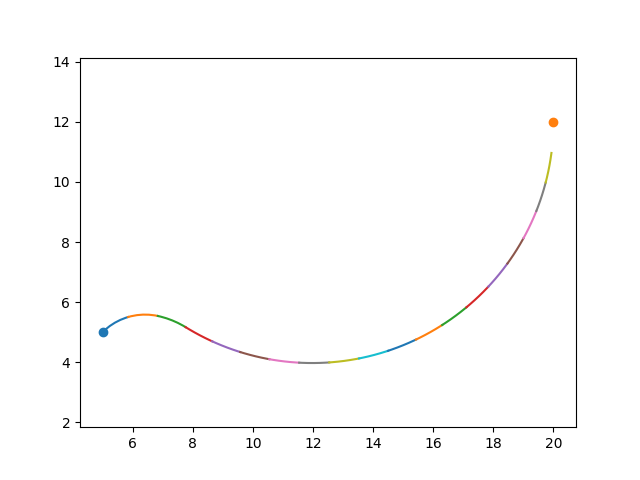

29.49101122604378
22.635581858137396
17.040285358536586
16.040453695600423
15.040220152318787
14.04017184493815
13.040172762580383
12.040219632750416
11.04011979656381
10.040117997590796
9.040096953364877
8.040139643038756
7.040116687527307
6.040145776962159
5.040098605932634
4.04009919197192
3.040100683524144
2.0401033072288417
1.0401069575147743


(4.25, 20.75, 3.572992364080538, 12.401286077900927)

In [42]:
q1 = start_q

target_pt = (20,12, np.pi/2)
dist = arc_dist(q1, target_pt)

fig, ax = plt.subplots()
ax.scatter(start_q[0], start_q[1])
ax.scatter(target_pt[0], target_pt[1])
trajectories = []
count = 0
while dist > 2 and count < 100:
    timestep = 1
    best_k, best_traj, collided = get_best_control(q1, target_pt, timestep)
#     print(best_k)
    ax.plot(best_traj[0], best_traj[1])
    trajectories.append(best_traj)
    q1 = best_traj[:, -1]
    dist = arc_dist(q1, target_pt)
    print(dist)
    count += 1


ax.axis("equal")

<IPython.core.display.Javascript object>


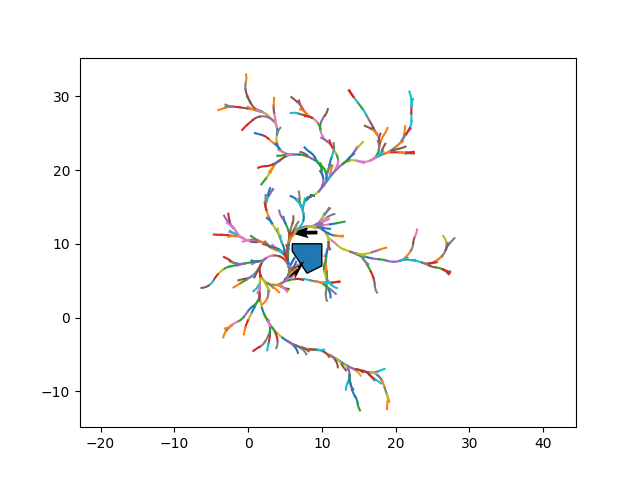

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


In [78]:
def try_add(graph, target, timestep):
    near = graph.nearest(target)
    best_k, best_traj, collided = get_best_control(near, target, timestep)
    new_q = best_traj[:,-1]
    
    if graph.dist_func(new_q, target) > graph.dist_func(near, target):
        graph.nodes[near].terminal = True
    
    

    if not collided:
        new_pt = tuple(best_traj[:, -1])

        graph += (near, new_pt, best_k)

        return graph, best_traj
    else:
        return graph, None


goal_q = (12, 12, np.pi/2)
goal_q = (12, 12, np.pi)
goal_q = (15,15,0)
goal_q = tuple(np.random.uniform([0, 0, 0], [30, 30, 2*np.pi]))


def generate_graph(dist_func):
    g = Graph(dist_func)

    g.nodes[start_q] = Node(start_q, g.hfunc)

    near = g.nearest(goal_q)
    goal_dist = arc_dist(near, goal_q)
    min_goal_dist = np.Inf

    while goal_dist > 2:
        q_rand = tuple(np.random.uniform([-10, -10, 0], [40, 40, 2*np.pi]))
#         print(q_rand)
        g, best_traj = try_add(g, q_rand, 1)
        if best_traj is not None:
            yield best_traj, q_rand
        g, best_traj = try_add(g, goal_q, 1)
        if best_traj is not None:
            yield best_traj, q_rand
        near = g.nearest(goal_q)
        goal_dist = arc_dist(near, goal_q)
        if goal_dist < min_goal_dist:
            min_goal_dist = goal_dist
            print(goal_dist)
    return


fig, ax = plt.subplots()

obs_patch = dc.PolygonPatch(obs)
ax.add_patch(obs_patch)
# rand_pt, = ax.plot(0,0,'rs')
ax.quiver(start_q[0], start_q[1], np.cos(start_q[2]), np.sin(start_q[2]))
# ax.plot(goal_q[0], goal_q[1], 'rs')
ax.quiver(goal_q[0],goal_q[1], np.cos(goal_q[2]), np.sin(goal_q[2]))
ax.axis('equal')


def anim_func(data):
    traj = data[0]
#     rand_pt = data[1]
    l, = ax.plot(traj[0], traj[1])
#     rand_pt.set_data([rand_pt[0]],[rand_pt[1]])
    return l


animation = anim.FuncAnimation(
    fig, anim_func, generate_graph(arc_dist), interval=0, repeat=False)
        


<IPython.core.display.Javascript object>


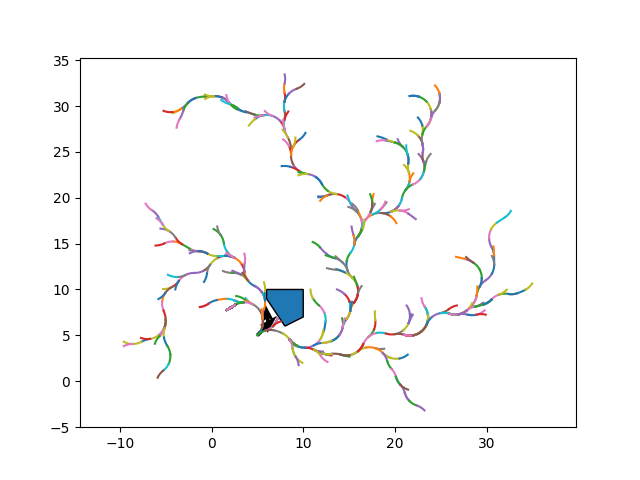

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


In [76]:
import dubins

def dubins_dist(q1, q2):
    path = dubins.shortest_path(q1, q2, 1/max_k)
    return path.path_length()

goal_q = tuple(np.random.uniform([0, 0, 0], [30, 30, 2*np.pi]))

fig, ax = plt.subplots()

obs_patch = dc.PolygonPatch(obs)
ax.add_patch(obs_patch)
# rand_pt, = ax.plot(0,0,'rs')
ax.quiver(start_q[0], start_q[1], np.cos(start_q[2]), np.sin(start_q[2]))
# ax.plot(goal_q[0], goal_q[1], 'rs')
ax.quiver(goal_q[0],goal_q[1], np.cos(goal_q[2]), np.sin(goal_q[2]))
ax.axis('equal')

animation = anim.FuncAnimation(
    fig, anim_func, generate_graph(dubins_dist), interval=0, repeat=False)